In [20]:

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os


In [21]:
import tensorflow as tf
from keras import Sequential
from keras.layers import Input, Conv2D, Dense, Add, Flatten, MaxPooling2D, AveragePooling2D, Activation, Input, BatchNormalization, Dropout, Concatenate
from keras.models import Model
from keras.utils import to_categorical

In [22]:
import keras.backend as K
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

In [23]:
from scipy.optimize import fmin_l_bfgs_b

# ***Visualizing augmented images of the style image***

In [24]:
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [25]:
path = '../input/black-ice-style-transfer/black_ice.jpg'

img = image.load_img(path, target_size=(300,400))

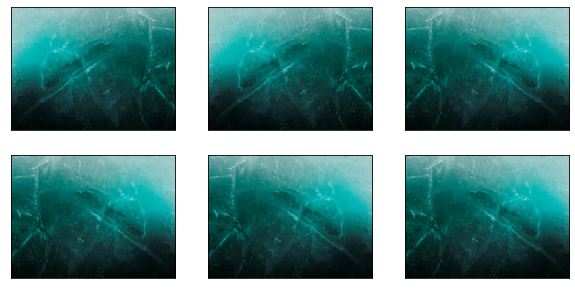

In [26]:
datagen = ImageDataGenerator(horizontal_flip=True,rescale=1/255)
 
data_generator = datagen.flow(np.expand_dims(img,0),batch_size=1)
 
# Display some augmented samples
plt.figure(figsize=(10,5))
for i in range(6):
    plt.subplot(2,3,i+1)
    for x in data_generator:
        plt.imshow(x[0])
        plt.xticks([])
        plt.yticks([])
        break



(1, 300, 400, 3)
<class 'keras_preprocessing.image.numpy_array_iterator.NumpyArrayIterator'>
<class 'PIL.Image.Image'>


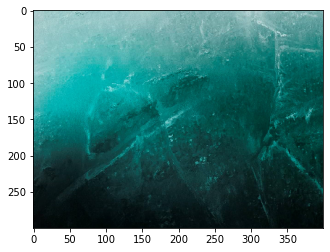

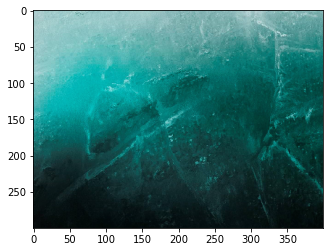

In [27]:
augmentor = ImageDataGenerator(channel_shift_range = 3, rescale=1/255)
IMG = augmentor.flow(np.expand_dims(img,0), batch_size=1)
print(next(IMG).shape)
print(type(IMG))
print(type(img))
plt.imshow(np.asarray(img),vmin=0,vmax=255)
plt.show()
#print(x[0])
plt.imshow(next(IMG)[0])
plt.show()

# ***keras.preprocessing.image.img_to_array scales up the natural image just like ImageDataGenerator***

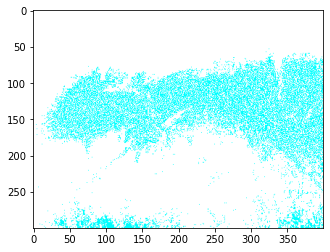

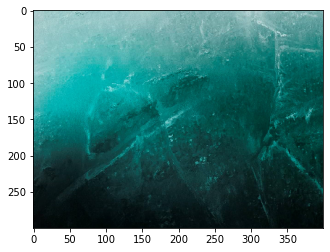

In [28]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
idg_image = x

plt.imshow(idg_image[0])
plt.show()


plt.imshow(idg_image[0]/255)
plt.show()



# ***Summarizing the VGG16 model***

In [29]:
shape = (300,400,3)
vgg = VGG16(input_shape=shape, weights='imagenet', include_top=False)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 400, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 400, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 400, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 200, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 200, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 200, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 100, 128)      0     

In [30]:
def VGG16_AvgPool(shape):
    # we want to account for features across the entire image
    # so get rid of the maxpool which throws away information
    vgg = VGG16(input_shape=shape, weights='imagenet', include_top=False)

    new_model = Sequential()
    #new_model.add(Input(shape= (None,shape[0],shape[1],shape[2])))
    for layer in vgg.layers:
        print(layer.name)
        if layer.__class__ == MaxPooling2D:
          # replace it with average pooling
            new_model.add(AveragePooling2D())
        else:
            new_model.add(layer)
    #new_model.build(input_shape=(None,shape[0],shape[1],3))
    new_model.summary()
    return new_model

def VGG16_AvgPool_CutOff(shape, num_convs):
    # there are 13 convolutions in total
    # we can pick any of them as the "output"
    # of our content model
    print(shape, 'XDXDXD')
    if num_convs < 1 or num_convs > 13:
        print("num_convs must be in the range [1, 13]")
        return None

    model = VGG16_AvgPool(shape)
    new_model = Sequential()
    new_model.add(VGG16(input_shape=shape, weights='imagenet', include_top=False).layers[0])
    n = 0
    for layer in model.layers:
        print(layer.name,' :3')
        if layer.__class__ == Conv2D:
            n += 1
        new_model.add(layer)
        if n >= num_convs:
            break
    new_model.summary()
    #new_model.build(input_shape=(None,shape[0],shape[1],3))
    return new_model


def unpreprocess(img):
    img[..., 0] += 103.939
    img[..., 1] += 116.779
    img[..., 2] += 126.68
    img = img[..., ::-1]
    return img


def scale_img(x):
    x = x - x.min()
    x = x / x.max()
    return x





In [31]:
def gram_matrix(img):
    # input is (H, W, C) (C = # feature maps)
    # we first need to convert it to (C, H*W)
    X = K.batch_flatten(K.permute_dimensions(img, (2, 0, 1)))

    # now, calculate the gram matrix
    # gram = XX^T / N
    # the constant is not important since we'll be weighting these
    G = K.dot(X, K.transpose(X)) / img.get_shape().num_elements()
    return G


def style_loss(y, t):
    return K.mean(K.square(gram_matrix(y) - gram_matrix(t)))


# let's generalize this and put it into a function



# ***Extracting the content from content image by using feature inversion***

(1, 300, 400, 3)
(300, 400, 3) XDXDXD
input_14
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 300, 400, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 400, 64)      36928     
_________________________________________________________________
average_pooling2d_50 (Averag (None, 150, 200, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 200, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 

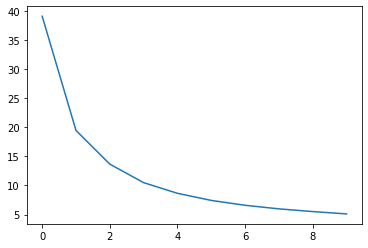

In [56]:

path = '../input/black-ice-style-transfer/Content/IMG_20190908_055620.jpg'
''''
####MODIFIED
'''
img = image.load_img(path, target_size= (300,400))     
# convert image to array and preprocess for vgg
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
idg_image = x
x = preprocess_input(x)
print(x.shape)

# we'll use this throughout the rest of the script
batch_shape = x.shape
shape = x.shape[1:]

# see the image
# plt.imshow(img)
# plt.show()


# make a content model
# try different cutoffs to see the images that result

'''
change the second parameter of 'VGG16_AvgPool_CutOff' to change the layer at which feature inversion takes place

'''


content_model = VGG16_AvgPool_CutOff(shape, 11)
#content_model.summary()
# make the target
target = K.variable(content_model.predict(x))


# try to match the image


#########
# define our loss in keras
loss = K.mean(K.square(target - content_model.output))



# gradients which are needed by the optimizer
grads = K.gradients(loss, content_model.input)
#########


# just like theano.function
get_loss_and_grads = K.function(
inputs=[content_model.input],
outputs=[loss] + grads
)

def get_loss_and_grads_wrapper(x_vec):
    # scipy's minimizer allows us to pass back
    # function value f(x) and its gradient f'(x)
    # simultaneously, rather than using the fprime arg
    #
    # we cannot use get_loss_and_grads() directly
    # input to minimizer func must be a 1-D array
    # input to get_loss_and_grads must be [batch_of_images]
    #
    # gradient must also be a 1-D array
    # and both loss and gradient must be np.float64
    # will get an error otherwise

    l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)


from datetime import datetime
t0 = datetime.now()
losses = []
x = np.random.randn(np.prod(batch_shape))
for i in range(10):
    x, l, _ = fmin_l_bfgs_b(
      func=get_loss_and_grads_wrapper,
      x0=x,
      # bounds=[[-127, 127]]*len(x.flatten()),
      maxfun=20
    )
    x = np.clip(x, -127, 127)
    # print("min:", x.min(), "max:", x.max())
    print("iter=%s, loss=%s" % (i, l))
    losses.append(l)

print("duration:", datetime.now() - t0)
plt.plot(losses)
plt.show()

newimg = x.reshape(*batch_shape)
final_img = unpreprocess(newimg)


######
feature_inv_content = scale_img(final_img[0])


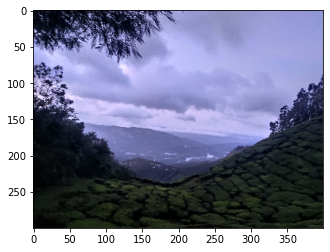

In [57]:
plt.imshow(img)

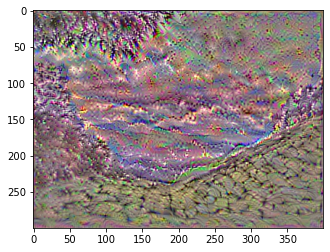

In [58]:
#Feature inversion done with 11th Conv layer as reference
plt.imshow(scale_img(final_img[0]))
plt.show()

# ***Extracting the style from style image by minimizing diff. of gram matrices inversion***

input_24
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 300, 400, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 400, 64)      36928     
_________________________________________________________________
average_pooling2d_95 (Averag (None, 150, 200, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 200, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 200, 128)     147584    
_____________

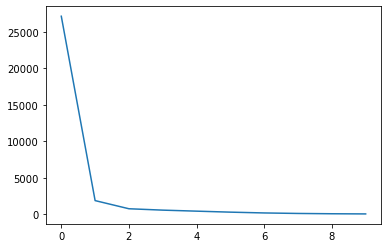

In [74]:

path = '../input/black-ice-style-transfer/black_ice.jpg'


# load the data
img = image.load_img(path, target_size=(300,400))

# convert image to array and preprocess for vgg
x = image.img_to_array(img)

# look at the image
# plt.imshow(x)
# plt.show()

# make it (1, H, W, C)
x = np.expand_dims(x, axis=0)

# preprocess into VGG expected format
x = preprocess_input(x)

# we'll use this throughout the rest of the script
batch_shape = x.shape
shape = x.shape[1:]

# let's take the first convolution at each block of convolutions
# to be our target outputs
# remember that you can print out the model summary if you want
vgg = VGG16_AvgPool(shape)

# Note: need to select output at index 1, since outputs at
# index 0 correspond to the original vgg with maxpool
symbolic_conv_outputs = [
    layer.get_output_at(1) for layer in vgg.layers \
    if layer.name.endswith('conv1')
]

# pick the earlier layers for
# a more "localized" representation
# this is opposed to the content model
# where the later layers represent a more "global" structure
# symbolic_conv_outputs = symbolic_conv_outputs[:2]

# make a big model that outputs multiple layers' outputs
multi_output_model = Model(vgg.input, symbolic_conv_outputs)

# calculate the targets that are output at each layer
style_layers_outputs = [K.variable(y) for y in multi_output_model.predict(x)]

'''
# calculate the total style loss
loss = 0
for symbolic, actual in zip(symbolic_conv_outputs, style_layers_outputs):
# gram_matrix() expects a (H, W, C) as input
    loss += style_loss(symbolic[0], actual[0])
'''
print(len(style_layers_outputs))

style_weights = [1,1,1,0,10]

loss =0

for w, symbolic, actual in zip(style_weights, symbolic_conv_outputs, style_layers_outputs):
  # gram_matrix() expects a (H, W, C) as input
    loss += w * style_loss(symbolic[0], actual[0])    

'''
The weighted some of the differences of the gram matrices at different conv. layers
is considered to be the loss, these weights affect the variation of the style of the image,
hence, these weights 'style_weights' are hyperparameters here

'''
grads = K.gradients(loss, multi_output_model.input)

# just like theano.function
get_loss_and_grads = K.function(
inputs=[multi_output_model.input],
outputs=[loss] + grads
)

def minimize(fn, epochs, batch_shape):
    t0 = datetime.now()
    losses = []
    x = np.random.randn(np.prod(batch_shape))
    for i in range(epochs):
        x, l, _ = fmin_l_bfgs_b(
          func=fn,
          x0=x,
          maxfun=20
        )
        x = np.clip(x, -127, 127)
        print("iter=%s, loss=%s" % (i, l))
        losses.append(l)

    print("duration:", datetime.now() - t0)
    plt.plot(losses)
    plt.show()

    newimg = x.reshape(*batch_shape)
    final_img = unpreprocess(newimg)
    return final_img[0]

def get_loss_and_grads_wrapper(x_vec):
    # scipy's minimizer allows us to pass back
    # function value f(x) and its gradient f'(x)
    # simultaneously, rather than using the fprime arg
    #
    # we cannot use get_loss_and_grads() directly
    # input to minimizer func must be a 1-D array
    # input to get_loss_and_grads must be [batch_of_images]
    # gradient must also be a 1-D array
    # and both loss and gradient must be np.float64
    # will get an error otherwise

    l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)



final_img = minimize(get_loss_and_grads_wrapper, 10, batch_shape)


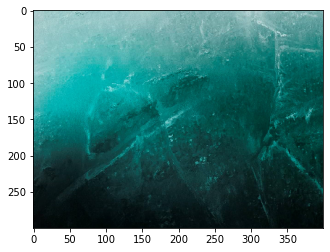

In [39]:
plt.imshow(img)

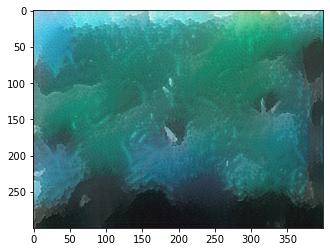

In [75]:
#[1,1,1,0,10]
plt.imshow(scale_img(final_img))
plt.show()

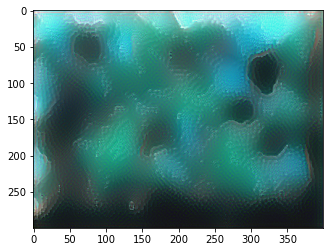

In [40]:
#[3,7,0,0,0]
plt.imshow(scale_img(final_img))
plt.show()

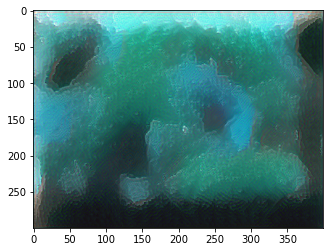

In [49]:
#[3,7,0,6,14]
plt.imshow(scale_img(final_img))
plt.show()

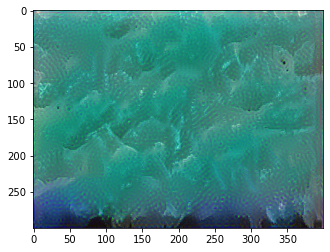

In [67]:
#[0,0,5,3,7]
plt.imshow(scale_img(final_img))
plt.show()

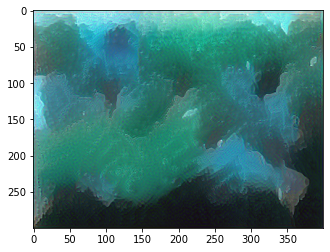

In [51]:
#[0.3,0.7,0,6,14]
plt.imshow(scale_img(final_img))
plt.show()

what f_minunc_bfgs_l does is basically:
--> it accepts a function(name= f) and its derivative function(name=f') as an input
--> it accepts an initial estimate as an input (x0)
--> the initial estimate is treated as the input to the function(name) passed earlier and gets argmin(x0)(f) (i.e, a value of x such that f(x) is minimum)

input_26
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 300, 400, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 400, 64)      36928     
_________________________________________________________________
average_pooling2d_105 (Avera (None, 150, 200, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 200, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 200, 128)     147584    
_____________

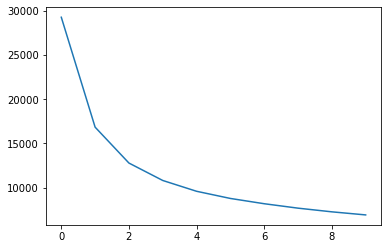

In [78]:
# load the content image
def load_img_and_preprocess(path, shape=(300,400)):
    img = image.load_img(path, target_size=shape)

    # convert image to array and preprocess for vgg
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    return x



content_img = load_img_and_preprocess(
  '../input/black-ice-style-transfer/Content/IMG_20190908_055620.jpg',
)

# resize the style image
# since we don't care too much about warping it
h, w = content_img.shape[1:3]
style_img = load_img_and_preprocess(
  '../input/black-ice-style-transfer/black_ice.jpg',
  (h, w)
)


# we'll use this throughout the rest of the script
batch_shape = content_img.shape
shape = content_img.shape[1:]


# we want to make only 1 VGG here, the final model needs
# to have a common input
vgg = VGG16_AvgPool(shape)


# create the content model
# we only want 1 output
# 1,2,4,5,7-9,11-13,15-17

'''
change the second parameter of 'VGG16_AvgPool_CutOff' to change the layer at which feature inversion takes place

'''

content_model = Model(vgg.input, vgg.layers[10].get_output_at(0))
content_target = K.variable(content_model.predict(content_img))


# create the style model


symbolic_conv_outputs = [
  layer.get_output_at(1) for layer in vgg.layers \
  if layer.name.endswith('conv1')
]

# make a big model that outputs multiple layers' outputs
style_model = Model(vgg.input, symbolic_conv_outputs)

# calculate the targets that are output at each layer
style_layers_outputs = [K.variable(y) for y in style_model.predict(style_img)]

# we will assume the weight of the content loss is 1
# and only weight the style losses

'''
this assigns weight to the losses of gram matrices at various stages
'''

style_weights = [10,0,0,0,0]


'''
# create the total loss which is the sum of content + style loss
'''
loss = K.mean(K.square(content_model.output - content_target))

for w, symbolic, actual in zip(style_weights, symbolic_conv_outputs, style_layers_outputs):
  # gram_matrix() expects a (H, W, C) as input
    loss += w * style_loss(symbolic[0], actual[0])

# note: it doesn't matter which model's input you use
# they are both pointing to the same keras Input layer in memory
grads = K.gradients(loss, vgg.input)

# creating a Keras symbolic function
get_loss_and_grads = K.function(
  inputs=[vgg.input],
  outputs=[loss] + grads
)


def get_loss_and_grads_wrapper(x_vec):
    l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)



def minimize(fn, epochs, batch_shape):
    t0 = datetime.now()
    losses = []
    x = np.random.randn(np.prod(batch_shape))
    for i in range(epochs):
        x, l, _ = fmin_l_bfgs_b(
          func=fn,
          x0=x,
          maxfun=20
        )
        x = np.clip(x, -127, 127)
        print("iter=%s, loss=%s" % (i, l))
        losses.append(l)

    print("duration:", datetime.now() - t0)
    plt.plot(losses)
    plt.show()

    newimg = x.reshape(*batch_shape)
    final_img = unpreprocess(newimg)
    return final_img[0]


final_img = minimize(get_loss_and_grads_wrapper, 10, batch_shape)



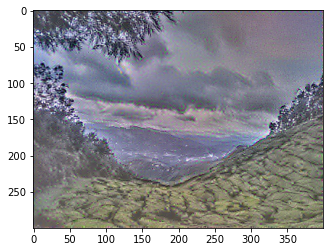

In [79]:
plt.imshow(scale_img(final_img))
plt.show()

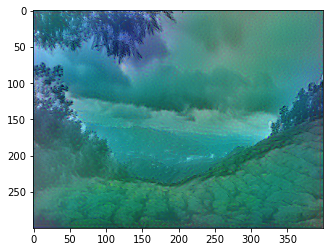

In [63]:
#[3,7,0,6,14] are the gram matrices' loss weights used at different layers
plt.imshow(scale_img(final_img))
plt.show()

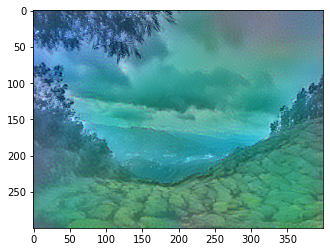

In [77]:
plt.imshow(scale_img(final_img))
plt.show()